In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


# We use Python's `functools.partial` to create a new function based on `fast_system` 
# with "eps" set to zero.
from functools import partial
from scipy.integrate import odeint
from sympy import symbols, Eq, solve, Function, Matrix, diff
#from scipy.integrate import solve_ivp


# Define the ODE systems
def fast_system(y, t, eps):
    x, y, z = y
    dxdt = -x
    dydt = 2 * y + eps * x
    dzdt = eps * (x**2 + 1)
    return [dxdt, dydt, dzdt]

# Create a new function, "fast_subsystem" with eps=0 based on fast_system
fast_subsystem = partial(fast_system, eps=0)

# Define the Jacobian function
def jacobian(func, y):
    n = len(y)
    J = np.zeros((n, n))
    for i in range(n):
        epsilon = 1e-6  # Small perturbation
        y_perturbed = np.array(y.copy(), dtype=float)  
        y_perturbed[i] += epsilon
        dy = np.array(func(y_perturbed, 0)) - np.array(func(y, 0))
        J[:, i] = dy / epsilon
    return J

# Find equilibrium points of fast_subsystem numerically
equilibrium_points = [np.zeros(len(fast_system([0, 0, 0], 0, 0)))] # [np.zeros(len(y))]

# Compute Jacobian matrix at each equilibrium point
for eq_point in equilibrium_points:
    J_eq = jacobian(fast_subsystem, eq_point)
    eigenvalues, eigenvectors = np.linalg.eig(J_eq)
    print("Jacobian Matrix:")
    print(J_eq)
    print("Eigenvalues:")
    print(eigenvalues)
    print("Eigenvectors:")
    print(eigenvectors)
    print()
    # Check if any eigenvalue has a pure imaginary part
    if any(np.imag(eigenvalues) != 0):
        print("The system is NOT NORMALLY HYPERBOLIC. Stopping...")
        break
    else:
        print("The system is NORMALLY HYPERBOLIC. Proceeding...\n")

def slow_system(y, tau, eps):
    x, y, z = y
    dxdtau = -x/eps
    dydtau = (2 * y + eps * x)/eps
    dzdtau = x**2 + 1
    return [dxdtau, dydtau, dzdtau]

def slow_subsystem(y, tau):
    x, y, z = y
    dxdtau = 0
    dydtau = 0
    dzdtau = x**2 + 1
    return [dxdtau, dydtau, dzdtau]



eps = 0.01
# Initial points x, y, z:
x_init, y_init, z_init = 1.0 + 0 * eps, 0.0 - 0 * eps, 0.0 + 0 * eps
print('The initial points of the BVP:', f"x_init = {x_init}, y_init = {y_init}, z_init = {z_init}")

t_end = 100
t  =  np.linspace(0, t_end, 200)
t2  =  np.linspace(0, -t_end, 200)

T_slow_end = 1
tau = np.linspace(0, T_slow_end, 200)


x_end, y_end, z_end = 0.0 - 0 * eps, 1.0 + 0 * eps, 1.0 + 0 * eps
print('The ending points of the BVP:', f"x_end = {x_end}, y_end = {y_end}, z_end = {z_end}")

# Define the exact solution
def fast_solution(t, eps, x0, y0, z0):
    lambda1, lambda2, lambda3 = eigenvalues
    x_real_fast = x0 * np.exp(lambda1 * t)
    y_real_fast = y0 * np.exp(lambda2 * t)
    z_real_fast = np.full_like(t, z0)
    return x_real_fast, y_real_fast, z_real_fast

def slow_solution(tau, eps, x0, y0, z0):
    lambda_slow = eigenvalues[0]
    x_real_slow = np.full_like(tau, 0)
    y_real_slow = np.full_like(tau, 0)
    z_real_slow = z0 + tau
    return x_real_slow, y_real_slow, z_real_slow



# Exact solution
x_exact_fast, y_exact_fast, z_exact_fast = fast_solution(t, eps, x_init, y_init, z_init)
xf_end, yf_end, zf_end = x_exact_fast[-1], y_exact_fast[-1], z_exact_fast[-1]
x_exact_slow, y_exact_slow, z_exact_slow = slow_solution(tau, eps, xf_end, yf_end, zf_end)
x_exact_fast2, y_exact_fast2, z_exact_fast2 = fast_solution(t2, eps, x_end, y_end, z_end)



t_tensor = torch.tensor(t.reshape(-1, 1), dtype=torch.float64) 
tau_tensor = torch.tensor(tau.reshape(-1, 1), dtype=torch.float64)
t2_tensor = torch.tensor(t2.reshape(-1, 1), dtype=torch.float64)

def input_transform(t_tensor):
    return torch.cat([t_tensor], dim=1)

num_nrn = 5

class fast_system_PINN(nn.Module):
    def __init__(self):
        super(fast_system_PINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 3)

    def forward(self, t):
        x = F.tanh(self.fc1(t))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

class slow_system_PINN(nn.Module):
    def __init__(self):
        super(slow_system_PINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 3)

    def forward(self, tau):
        x = F.tanh(self.fc1(tau))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    
class fast_system_PINN2(nn.Module):
    def __init__(self):
        super(fast_system_PINN2, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 3)

    def forward(self, t2):
        x = F.tanh(self.fc1(t2))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    
phys_weight = 5

def loss_func_fast(model, t_tensor, x_init, y_init, z_init,\
                                   x_f_end, y_f_end, z_f_end, eps, random_points=10):
    t_tensor.requires_grad = True
    pred_fast = model(t_tensor)
    x_pred_fast, y_pred_fast, z_pred_fast = pred_fast[:, 0].unsqueeze(1),\
                                            pred_fast[:, 1].unsqueeze(1),\
                                            pred_fast[:, 2].unsqueeze(1)

           
    ones = torch.ones_like(x_pred_fast, requires_grad=True)  
    dx_dt = torch.autograd.grad(x_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dt = torch.autograd.grad(y_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dz_dt = torch.autograd.grad(z_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    #for the sub fast system
    residual1_fast = dx_dt + x_pred_fast
    residual2_fast = dy_dt - 2 * y_pred_fast
    residual3_fast = dz_dt
    #for the main fast system
    residual4_fast = dy_dt - 2 * y_pred_fast - eps * x_pred_fast
    residual5_fast = dz_dt - eps * (x_pred_fast**2 + 1)
    
    init_loss_fast = torch.square(x_pred_fast[0] - x_init) +\
                     torch.square(y_pred_fast[0] - y_init) +\
                     torch.square(z_pred_fast[0] - z_init)
    physics_loss_fast = torch.mean(residual1_fast**2 + residual2_fast**2 +\
                                   residual3_fast**2 + residual4_fast**2 +\
                                   residual5_fast**2)

    boundary_loss_fast = torch.square(x_pred_fast[-1] - x_f_end) +\
                         torch.square(y_pred_fast[-1] - y_f_end) +\
                         torch.square(z_pred_fast[-1] - z_f_end)
    
    
    total_loss_fast = phys_weight * physics_loss_fast + init_loss_fast + boundary_loss_fast

    return total_loss_fast

def loss_func_fast2(model, t2_tensor, x_end, y_end, z_end,\
                                    x_f2_end, y_f2_end, z_f2_end, eps, random_points=10):
    t2_tensor.requires_grad = True
    pred_fast2 = model(t2_tensor)
    x_pred_fast2, y_pred_fast2, z_pred_fast2 = pred_fast2[:, 0].unsqueeze(1),\
                                               pred_fast2[:, 1].unsqueeze(1),\
                                               pred_fast2[:, 2].unsqueeze(1)
    
    ones = torch.ones_like(x_pred_fast2, requires_grad=True)  
    dx_dt2 = torch.autograd.grad(x_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dt2 = torch.autograd.grad(y_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dz_dt2 = torch.autograd.grad(z_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    #for the sub fast system
    residual1_fast2 = dx_dt2 + x_pred_fast2
    residual2_fast2 = dy_dt2 - 2 * y_pred_fast2
    residual3_fast2 = dz_dt2
    # Compute residuals for fast_subsystem
    residual4_fast2 = dy_dt2 - 2 * y_pred_fast2 - eps * x_pred_fast2
    residual5_fast2 = dz_dt2 - eps * (x_pred_fast2**2 + 1)
    
    init_loss_fast2 = torch.square(x_pred_fast2[0] - x_end) +\
                      torch.square(y_pred_fast2[0] - y_end) +\
                      torch.square(z_pred_fast2[0] - z_end)
    physics_loss_fast2 = torch.mean(residual1_fast2**2 + residual2_fast2**2 +\
                                    residual3_fast2**2 + residual4_fast2**2 +\
                                    residual5_fast2**2)
    boundary_loss_fast2 = torch.square(x_pred_fast2[-1] - x_f2_end) +\
                          torch.square(y_pred_fast2[-1] - y_f2_end) +\
                          torch.square(z_pred_fast2[-1] - z_f2_end)
    total_loss_fast2 = phys_weight * physics_loss_fast2 + init_loss_fast2 + boundary_loss_fast2

    return total_loss_fast2

def loss_func_slow(model, tau_tensor, x_1, y_1, z_1, x_2, y_2, z_2, eps, random_points=10):
    tau_tensor.requires_grad = True
    pred_slow = model(tau_tensor)
    x_pred_slow, y_pred_slow, z_pred_slow = pred_slow[:, 0].unsqueeze(1), pred_slow[:, 1].unsqueeze(1), pred_slow[:, 2].unsqueeze(1)   
    
    ones = torch.ones_like(x_pred_slow, requires_grad=True)
    dx_dtau = torch.autograd.grad(x_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dtau = torch.autograd.grad(y_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dz_dtau = torch.autograd.grad(z_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]

    residual1_slow = eps * dx_dtau + x_pred_slow  # dx_dtau + x_pred_slow / eps
    residual2_slow = eps * dy_dtau - (2 * y_pred_slow + eps * x_pred_slow) # dy_dtau - (2 * y_pred_slow + eps * x_pred_slow) / eps
    residual3_slow = dz_dtau - x_pred_slow**2 - 1

    residual4_slow = x_pred_slow
    residual5_slow = y_pred_slow
    
    init_loss_slow = torch.square(x_pred_slow[0] - x_1) +\
                     torch.square(y_pred_slow[0] - y_1) +\
                     torch.square(z_pred_slow[0] - z_1)
    physics_loss_slow = torch.mean(residual1_slow**2 + residual2_slow**2 + residual3_slow**2 + residual4_slow**2 + residual5_slow**2)
    
    boundary_loss_slow = torch.square(x_pred_slow[-1] - x_2) +\
                         torch.square(y_pred_slow[-1] - y_2) +\
                         torch.square(z_pred_slow[-1] - z_2)
    total_loss_slow = phys_weight * physics_loss_slow + init_loss_slow + boundary_loss_slow
    return total_loss_slow


def total_loss_func(model_fast, model_slow, model_fast2,\
                    t_tensor, tau_tensor, t2_tensor,\
                    x_init, y_init, z_init, x_f_end, y_f_end, z_f_end,\
                    x_1, y_1, z_1, x_2, y_2, z_2,\
                    x_end, y_end, z_end, x_f2_end, y_f2_end, z_f2_end, eps,\
                    weight_fast=1.0, weight_slow=1.0):
    loss_fast = loss_func_fast(model_fast, t_tensor, x_init, y_init, z_init,\
                                                   x_f_end, y_f_end, z_f_end, eps)
    loss_fast2 = loss_func_fast2(model_fast2, t2_tensor, x_end, y_end, z_end,\
                                                   x_f2_end, y_f2_end, z_f2_end, eps)
    loss_slow = loss_func_slow(model_slow, tau_tensor,\
                               x_1, y_1, z_1, x_2, y_2, z_2, eps)
    total_loss = weight_fast * loss_fast + weight_slow * loss_slow + weight_fast * loss_fast2
    
    return total_loss




Jacobian Matrix:
[[-1.  0.  0.]
 [ 0.  2.  0.]
 [ 0.  0.  0.]]
Eigenvalues:
[-1.  2.  0.]
Eigenvectors:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

The system is NORMALLY HYPERBOLIC. Proceeding...

The initial points of the BVP: x_init = 1.0, y_init = 0.0, z_init = 0.0
The ending points of the BVP: x_end = 0.0, y_end = 1.0, z_end = 1.0


Epoch 0, Total Loss: 28.225496631756027
Epoch 2000, Total Loss: 0.03226788407943873
Epoch 4000, Total Loss: 0.0018188117780978627
Epoch 6000, Total Loss: 0.0012297398332648903
Epoch 8000, Total Loss: 0.0012246143848344496
Epoch 10000, Total Loss: 0.0010795833328341605


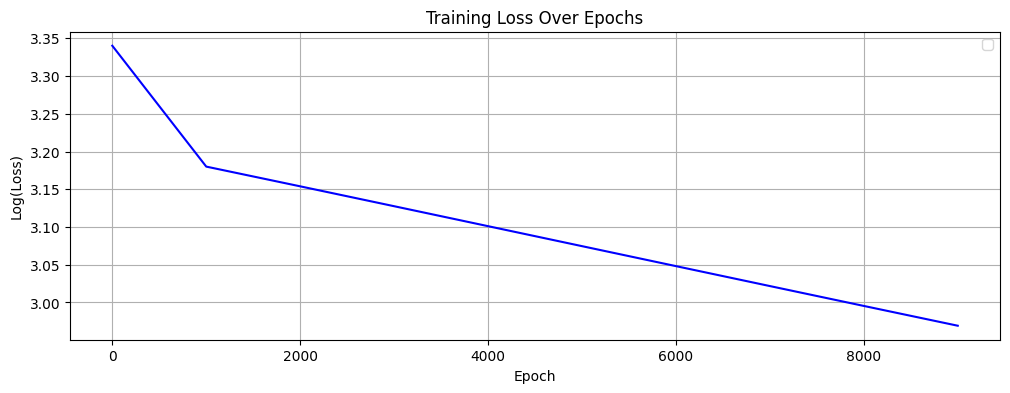

In [2]:
if __name__=='__main__':

    model_fast  = fast_system_PINN().to(torch.float64)  
    model_slow  = slow_system_PINN().to(torch.float64)
    model_fast2 = fast_system_PINN2().to(torch.float64) 

    optimizer = torch.optim.Adam(list(model_fast.parameters()) + list(model_slow.parameters()) + list(model_fast2.parameters()), lr=1e-3)
    loss_values = []
    epoch_num = 10000


    xf_end, yf_end, zf_end = np.random.random(), np.random.random(), np.random.random()    
    xf2_end, yf2_end, zf2_end = np.random.random(), np.random.random(), np.random.random()

    xs_init, ys_init, zs_init = np.random.random(), np.random.random(), np.random.random()
    xs_end, ys_end, zs_end = np.random.random(), np.random.random(), np.random.random()


    for epoch in range(epoch_num + 1):
        optimizer.zero_grad()
        loss_total = total_loss_func(model_fast, model_slow, model_fast2,\
                                     t_tensor, tau_tensor, t2_tensor,\
                                     x_init, y_init, z_init, xf_end, yf_end, zf_end,\
                                     xs_init, ys_init, zs_init,\
                                     xs_end, ys_end, zs_end,\
                                     x_end, y_end, z_end, xf2_end, yf2_end, zf2_end, eps,\
                                     weight_fast=1.0, weight_slow=1.0)
        loss_total.backward()#(retain_graph=True)
        optimizer.step()
        with torch.no_grad():
            x_pred_fast, y_pred_fast, z_pred_fast = model_fast(t_tensor).numpy().T
            x_pred_slow, y_pred_slow, z_pred_slow = model_slow(tau_tensor).numpy().T
            x_pred_fast2, y_pred_fast2, z_pred_fast2 = model_fast2(t2_tensor).numpy().T

            xf_end,  yf_end,  zf_end  = x_pred_slow[0], y_pred_slow[0], z_pred_slow[0]
            xs_init, ys_init, zs_init = x_pred_fast[-1], y_pred_fast[-1], z_pred_fast[-1]
            xs_end,  ys_end,  zs_end  = x_pred_fast2[-1], y_pred_fast2[-1], z_pred_fast2[-1]
            xf2_end, yf2_end, zf2_end = x_pred_slow[-1],  y_pred_slow[-1],  z_pred_slow[-1]

        if epoch % 2000 == 0:
            print(f'Epoch {epoch}, Total Loss: {loss_total.item()}')
            model_fast.train()
            model_slow.train()
            model_fast2.train()
            
            #print('xs_init, ys_init, zs_init are:', f"xs_init = {xs_init}, ys_init = {ys_init}, zs_init = {zs_init}")
            #print('xf_end, yf_end, zf_end are:', f"xf_end = {xf_end}, yf_end = {yf_end}, zf_end = {zf_end}")
            #print('xs_end, ys_end, zs_end are:', f"xs_end = {xs_end}, ys_end = {ys_end}, zs_end = {zs_end}")
            #print('xf2_end, yf2_end, zf2_end are:', f"xf2_end = {xf2_end}, yf2_end = {yf2_end}, zf2_end = {zf2_end}")

        loss_values.append(loss_total.item())
        
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    plt.plot(range(0, epoch_num, 1000), np.log(loss_values[:epoch_num//1000]), 'b')
    plt.xlabel('Epoch')
    plt.ylabel('Log(Loss)')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Model evaluation
    model_fast.eval()
    model_fast2.eval()
    model_slow.eval()
    with torch.no_grad():
        # Predictions for fast system
        x_pred_fast, y_pred_fast, z_pred_fast = model_fast(t_tensor).numpy().T
        # Predictions for slow system
        x_pred_slow, y_pred_slow, z_pred_slow = model_slow(tau_tensor).numpy().T
        # Predictions for fast system
        x_pred_fast2, y_pred_fast2, z_pred_fast2 = model_fast2(t2_tensor).numpy().T
        
    # Plotting the 3D trajectories
    
    
    
    

    
    


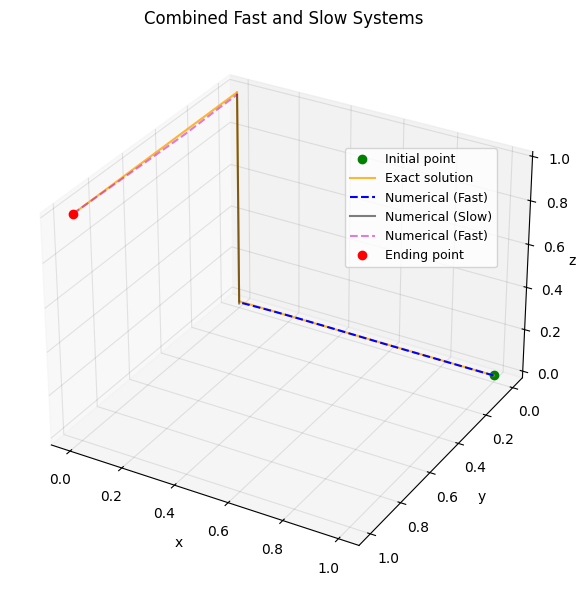

In [3]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(x_init, y_init, z_init, 'go', label='Initial point')


ax.plot(x_exact_fast, y_exact_fast, z_exact_fast, '-', color= 'orange', label='Exact solution', alpha=0.8)
ax.plot(x_exact_slow + x_pred_fast[-1], y_exact_slow+ x_pred_fast[-1], z_exact_slow+ x_pred_fast[-1], '-', color= 'orange',  alpha=0.8)
ax.plot(x_exact_fast2  , y_exact_fast2  , z_exact_fast2 , color= 'orange',  alpha=0.8)

ax.plot(x_pred_fast, y_pred_fast, z_pred_fast, 'b--', label='Numerical (Fast)')


ax.plot(x_pred_slow + x_pred_fast[-1],\
        y_pred_slow + y_pred_fast[-1],\
        z_pred_slow + z_pred_fast[-1], 'k-', label='Numerical (Slow)', alpha=0.5)



ax.plot(x_pred_fast2  , y_pred_fast2 , z_pred_fast2 , 'm--', label='Numerical (Fast)', alpha=0.5)
# Plotting slow system ending point
ax.plot(x_end, y_end, z_end, 'ro', label='Ending point')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z', labelpad=-1)
ax.set_title('Combined Fast and Slow Systems')
ax.legend(prop={'size': 9}, bbox_to_anchor=(0.6, 0.8))
ax.invert_yaxis()

ax.xaxis._axinfo['grid'].update(color=(0.1, 0.1, 0.1, 0.1)) 
ax.yaxis._axinfo['grid'].update(color=(0.1, 0.1, 0.1, 0.1))
ax.zaxis._axinfo['grid'].update(color=(0.1, 0.1, 0.1, 0.1))


plt.tight_layout()
plt.show()


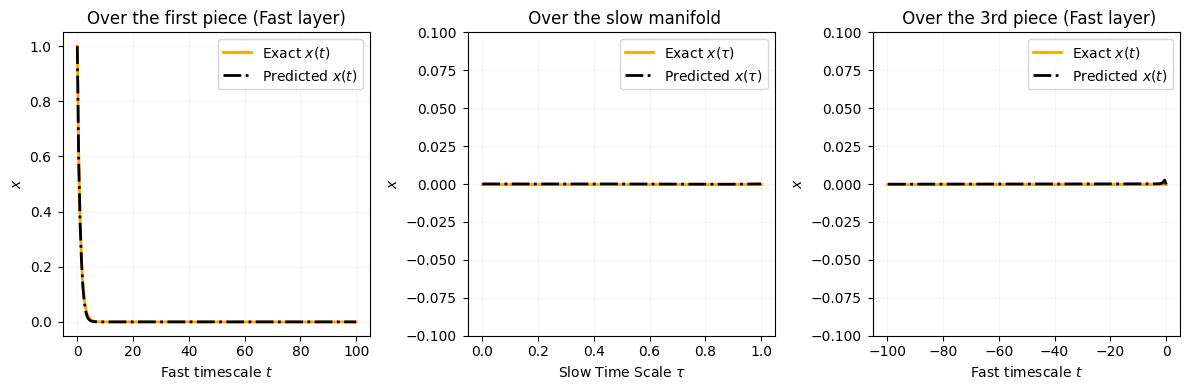

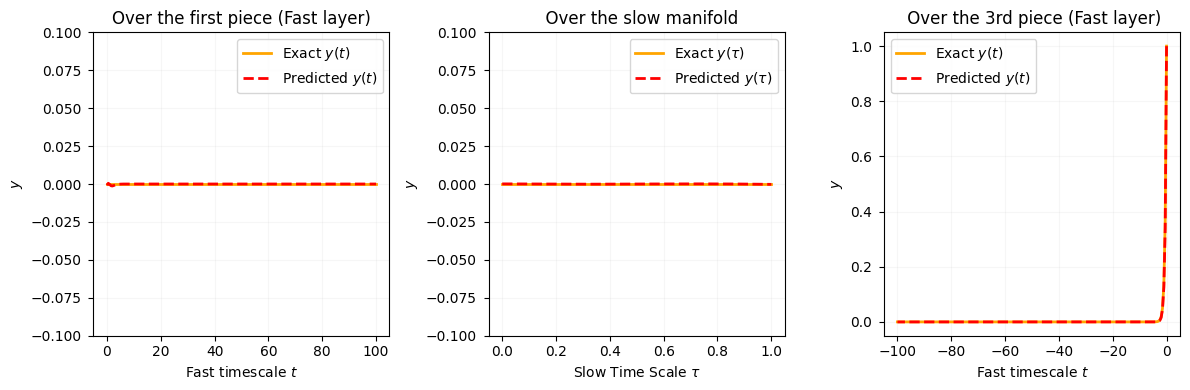

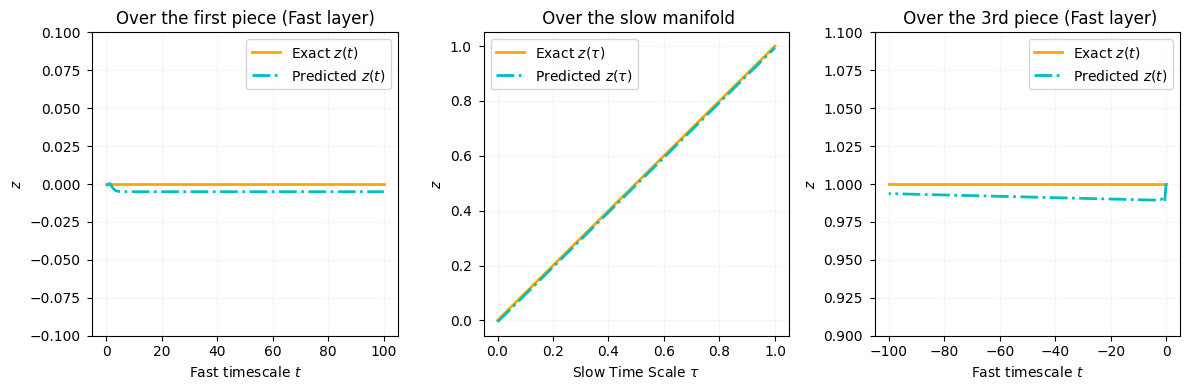

In [4]:
#########1st piece
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, x_exact_fast, '-', color='orange', linewidth=2, label='Exact $x(t)$')
plt.plot(t, x_pred_fast, '-.', color='black', linewidth=2, label='Predicted $x(t)$')
plt.xlabel('Fast timescale $t$')
plt.ylabel('$x$')
plt.grid(True, alpha=0.1)
plt.title('Over the first piece (Fast layer)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(tau, x_exact_slow + x_exact_fast[-1], '-', color='orange', linewidth=2, label='Exact $x(\\tau)$')
plt.plot(tau, x_pred_slow + x_exact_fast[-1], '-.', color='black', linewidth=2, label='Predicted $x(\\tau)$')
plt.xlabel('Slow Time Scale $\\tau$')
plt.ylabel('$x$')
plt.grid(True, alpha=0.1)
plt.ylim(-0.1, 0.1)
plt.title(' Over the slow manifold')
plt.legend()


plt.subplot(1, 3, 3)
plt.plot(t2, x_exact_fast2 , '-', color='orange', linewidth=2, label='Exact $x(t)$')
plt.plot(t2, x_pred_fast2 , '-.', color='black', linewidth=2, label='Predicted $x(t)$')
plt.xlabel('Fast timescale $t$')
plt.ylabel('$x$')
plt.ylim(-0.1, 0.1)
plt.grid(True, alpha=0.1)
plt.title(' Over the 3rd piece (Fast layer)')
plt.legend()

# Get the current axes and adjust y-axis tick label formatting for each subplot
for ax in plt.gcf().get_axes():
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))
    ax.yaxis.offsetText.set_fontsize(10) 
    ax.tick_params(axis='y', pad=5)  
plt.tight_layout()
plt.show()

########2nd piece
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, y_exact_fast, '-', color='orange', linewidth=2, label='Exact $y(t)$')
plt.plot(t, y_pred_fast, 'r--', linewidth=2, label='Predicted $y(t)$')
plt.xlabel('Fast timescale $t$')
plt.ylabel('$y$')
plt.ylim(-0.1, 0.1)
plt.grid(True, alpha=0.1)
plt.title('Over the first piece (Fast layer)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(tau, y_exact_slow + y_exact_fast[-1],  '-', color='orange', linewidth=2, label='Exact $y(\\tau)$')
plt.plot(tau, y_pred_slow + y_exact_fast[-1], 'r--', linewidth=2, label='Predicted $y(\\tau)$')
plt.xlabel('Slow Time Scale $\\tau$')
plt.ylabel('$y$')
plt.grid(True, alpha=0.1)
plt.ylim(-0.1, 0.1)
plt.title('  Over the slow manifold')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(t2, y_exact_fast2 , '-', color='orange', linewidth=2, label='Exact $y(t)$')
plt.plot(t2, y_pred_fast2 , 'r--', linewidth=2, label='Predicted $y(t)$')
plt.xlabel('Fast timescale $t$')
plt.ylabel('$y$')
plt.grid(True, alpha=0.1)
plt.title(' Over the 3rd piece (Fast layer)')
plt.legend()

# Adjust y-axis tick label formatting
for ax in plt.gcf().get_axes():
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))
    ax.yaxis.offsetText.set_fontsize(10) 
    ax.tick_params(axis='y', pad=5)

plt.tight_layout()
plt.show()

########3rd piece
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, z_exact_fast, '-', color='orange', linewidth=2, label='Exact $z(t)$')
plt.plot(t, z_pred_fast, 'c-.', linewidth=2, label='Predicted $z(t)$')
plt.xlabel('Fast timescale $t$')
plt.ylabel('$z$')
plt.grid(True, alpha=0.1)
plt.ylim(-0.1, 0.1)  # Corrected to plt.ylim
plt.title('Over the first piece (Fast layer)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(tau, z_exact_slow + z_exact_fast[-1], '-', color='orange', linewidth=2, label='Exact $z(\\tau)$')
plt.plot(tau, z_pred_slow + z_exact_fast[-1], 'c-.', linewidth=2, label='Predicted $z(\\tau)$')
plt.xlabel('Slow Time Scale $\\tau$')
plt.ylabel('$z$')
plt.grid(True, alpha=0.1)
plt.title(' Over the slow manifold')
plt.legend()


plt.subplot(1, 3, 3)
plt.plot(t2, z_exact_fast2 , '-', color='orange', linewidth=2, label='Exact $z(t)$')
plt.plot(t2, z_pred_fast2 , 'c-.', linewidth=2, label='Predicted $z(t)$')
plt.xlabel('Fast timescale $t$')
plt.ylabel('$z$')
plt.ylim(0.9, 1.1)
plt.title(' Over the 3rd piece (Fast layer)')
plt.legend()
for ax in plt.gcf().get_axes():
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))
    ax.yaxis.offsetText.set_fontsize(10) 
    ax.tick_params(axis='y', pad=5)

plt.grid(True, alpha=0.1)

plt.tight_layout()
plt.show()


In [5]:
# Calculate the error
x_error_fast = np.abs(x_exact_fast - x_pred_fast)
y_error_fast = np.abs(y_exact_fast - y_pred_fast)
z_error_fast = np.abs(z_exact_fast - z_pred_fast)

x_error_slow = np.abs(x_exact_slow - x_pred_slow )
y_error_slow = np.abs(y_exact_slow - y_pred_slow )
z_error_slow = np.abs(z_exact_slow - z_pred_slow )

x_error_fast2 = np.abs(x_exact_fast2 - x_pred_fast2)
y_error_fast2 = np.abs(y_exact_fast2 - y_pred_fast2)
z_error_fast2 = np.abs(z_exact_fast2 - z_pred_fast2)

# Normalize the error
x_error_fast_norm = x_error_fast 
y_error_fast_norm = y_error_fast
z_error_fast_norm = z_error_fast 

x_error_slow_norm = x_error_slow
y_error_slow_norm = y_error_slow 
z_error_slow_norm = z_error_slow 

x_error_fast2_norm = x_error_fast2
y_error_fast2_norm = y_error_fast2 
z_error_fast2_norm = z_error_fast2 


# Maximum error
max_x_error = np.max(x_error_fast)
max_y_error = np.max(y_error_fast)
max_z_error = np.max(z_error_fast)

print("Maximum errors for the first piece (Fast layer):")
print("Max x error:", max_x_error)
print("Max y error:", max_y_error)
print("Max z error:", max_z_error)



# Maximum error for the slow layer
max_x_error_slow = np.max(x_error_slow)
max_y_error_slow = np.max(y_error_slow)
max_z_error_slow = np.max(z_error_slow)

print("Maximum errors over the slow manifold:")
print("Max x error:", max_x_error_slow)
print("Max y error:", max_y_error_slow)
print("Max z error:", max_z_error_slow)


# Maximum error for the third piece
max_x_error_fast2 = np.max(x_error_fast2)
max_y_error_fast2 = np.max(y_error_fast2)
max_z_error_fast2 = np.max(z_error_fast2)

print("Maximum errors over the third piece (Fast layer):")
print("Max x error:", max_x_error_fast2)
print("Max y error:", max_y_error_fast2)
print("Max z error:", max_z_error_fast2)


Maximum errors for the first piece (Fast layer):
Max x error: 0.023005051868237092
Max y error: 0.001303169577798552
Max z error: 0.00506339642817541
Maximum errors over the slow manifold:
Max x error: 0.00015293878487987467
Max y error: 0.0002085094426961115
Max z error: 0.0059648547733544
Maximum errors over the third piece (Fast layer):
Max x error: 0.0026059040258324673
Max y error: 0.028278625034774463
Max z error: 0.011366029389844767


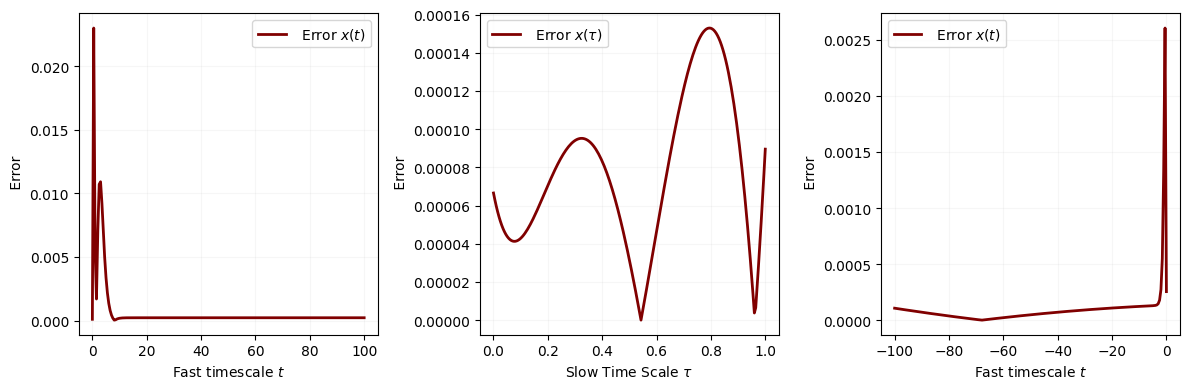

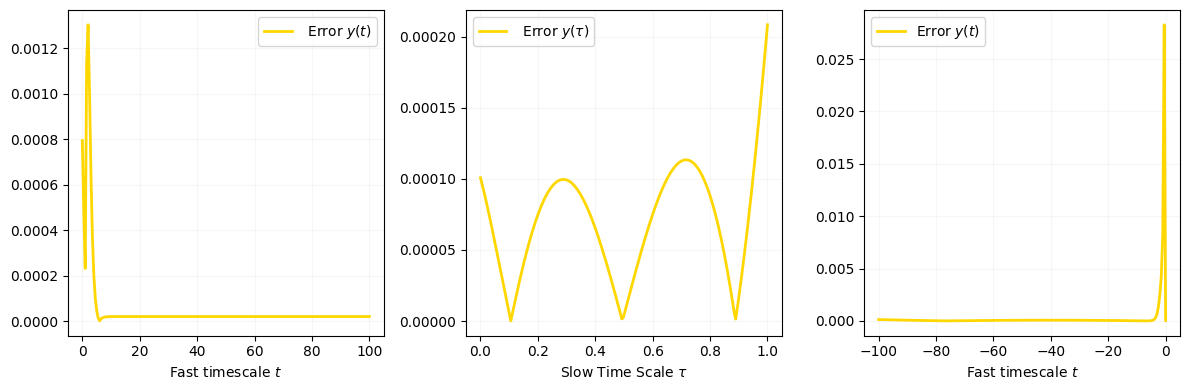

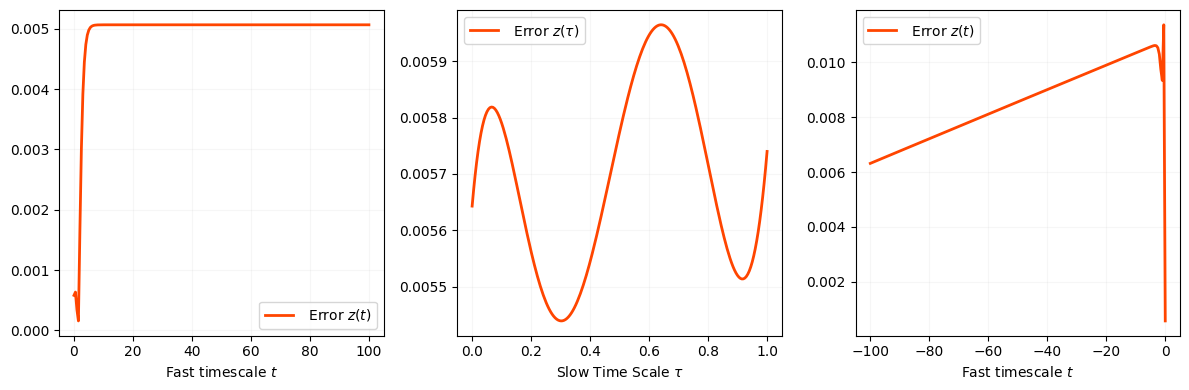

In [6]:
# Plot the normalized error
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, x_error_fast_norm, '-', color='maroon', linewidth=2, label=' Error $x(t)$')
plt.xlabel('Fast timescale $t$')
plt.ylabel(' Error')
plt.grid(True, alpha=0.1)
#plt.title('Normalized Error over the first piece (Fast layer)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(tau, x_error_slow_norm, '-', color='maroon', linewidth=2, label=' Error $x(\\tau)$')
plt.xlabel('Slow Time Scale $\\tau$')
plt.ylabel(' Error')
plt.grid(True, alpha=0.1)
#plt.title('Normalized Error over the slow manifold')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(t2, x_error_fast2_norm, '-', color='maroon', linewidth=2, label=' Error $x(t)$')
plt.xlabel('Fast timescale $t$')
plt.ylabel(' Error')
plt.grid(True, alpha=0.1)
#plt.title('Normalized Error over the 3rd piece (Fast layer)')
plt.legend()


plt.tight_layout()
plt.show()

# Repeat the same process for the slow layer and the third piece
# Plot for the slow layer
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, y_error_fast_norm, '-', color='gold', linewidth=2, label=' Error $y(t)$')
plt.xlabel('Fast timescale $t$')
#plt.ylabel(' Error')
plt.grid(True, alpha=0.1)
#plt.title('Normalized Error over the first piece (Fast layer)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(tau, y_error_slow_norm, '-', color='gold', linewidth=2, label=' Error $y(\\tau)$')
plt.xlabel('Slow Time Scale $\\tau$')
#plt.ylabel(' Error')
plt.grid(True, alpha=0.1)
#plt.title('Normalized Error over the slow manifold')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(t2, y_error_fast2_norm, '-', color='gold', linewidth=2, label='Error $y(t)$')
plt.xlabel('Fast timescale $t$')
plt.grid(True, alpha=0.1)
#plt.ylabel(' Error')
#plt.title('Normalized Error over the 3rd piece (Fast layer)')
plt.legend()

plt.tight_layout()
plt.show()

# Plot for the third piece (Fast layer)
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, z_error_fast_norm, '-', color='orangered', linewidth=2, label=' Error $z(t)$')
plt.xlabel('Fast timescale $t$')
plt.grid(True, alpha=0.1)
#plt.ylabel('Error')
#plt.title('Normalized Error over the first piece (Fast layer)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(tau, z_error_slow_norm, '-', color='orangered', linewidth=2, label=' Error $z(\\tau)$')
plt.xlabel('Slow Time Scale $\\tau$')
plt.grid(True, alpha=0.1)
#plt.ylabel(' Error')
#plt.title('Normalized Error over the slow manifold')
plt.legend()


plt.subplot(1, 3, 3)
plt.plot(t2, z_error_fast2_norm, '-', color='orangered', linewidth=2, label=' Error $z(t)$')
plt.xlabel('Fast timescale $t$')
plt.grid(True, alpha=0.1)
#plt.ylabel(' Error')
#plt.title('Normalized Error over the 3rd piece (Fast layer)')
plt.legend()

plt.tight_layout()
plt.show()



In [7]:



print("xf_end type:", type(xf_end))
print(xf_end)

print("x_pred_fast[-1] type:", type(x_pred_fast[-1]))
#print("x_pred_fast[-1] shape:", x_pred_fast[-1].shape)
print(x_pred_fast[-1])
xf_end = x_pred_fast[-1]
print(xf_end)
print("xf_end type:", type(xf_end))



xf_end type: <class 'numpy.float64'>
6.656334144608533e-05
x_pred_fast[-1] type: <class 'numpy.float64'>
0.00022248572573951853
0.00022248572573951853
xf_end type: <class 'numpy.float64'>


/tmp/ipykernel_18/2423547422.py:49: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
/tmp/ipykernel_18/2423547422.py:50: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
/tmp/ipykernel_18/2423547422.py:51: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


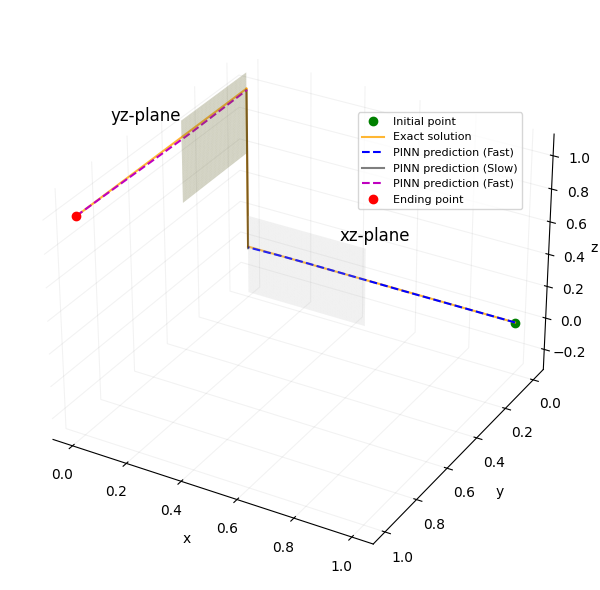

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('white')  # Set the background color of the 3D plot

ax.plot(x_init, y_init, z_init, 'go', label='Initial point')

ax.plot(x_exact_fast, y_exact_fast, z_exact_fast, '-', color='orange', label='Exact solution', alpha=0.8)
ax.plot(x_exact_slow + x_pred_fast[-1], y_exact_slow + x_pred_fast[-1], z_exact_slow + x_pred_fast[-1], '-', color='orange', alpha=0.8)
ax.plot(x_exact_fast2, y_exact_fast2, z_exact_fast2, color='orange', alpha=0.8)

# Plotting the xz-plane
x_plane = np.linspace(0, 0.45, 100)
z_plane = np.linspace(-0.3, 0.2, 100)
X_plane, Z_plane = np.meshgrid(x_plane, z_plane)
Y_plane = np.zeros_like(X_plane)
ax.plot_surface(X_plane, Y_plane, Z_plane, alpha=0.2, color='lightgrey')

# Plotting the yz-plane
y_plane = np.linspace(0, 0.4, 100)
z_plane = np.linspace(0.6, 1.1, 100)
Y_plane, Z_plane = np.meshgrid(y_plane, z_plane)
X_plane = np.zeros_like(Y_plane)
ax.plot_surface(X_plane, Y_plane, Z_plane, alpha=0.3, color=(1.0, 1.0, 0.5))

# Annotation for xz-plane using LaTeX
ax.text(0.35, 0, 0.2, r"xz-plane", color='black', fontsize=12, ha='left')

# Annotation for yz-plane using LaTeX
ax.text(0, 0.4, 1.1, r"yz-plane", color='black', fontsize=12, ha='right')

ax.plot(x_pred_fast, y_pred_fast, z_pred_fast, 'b--', label='PINN prediction (Fast)')
ax.plot(x_pred_slow + x_pred_fast[-1], y_pred_slow + y_pred_fast[-1], z_pred_slow + z_pred_fast[-1], 'k-', label='PINN prediction (Slow)', alpha=0.5)
ax.plot(x_pred_fast2, y_pred_fast2, z_pred_fast2, 'm--', label='PINN prediction (Fast)')

ax.plot(x_end, y_end, z_end, 'ro', label='Ending point')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z', labelpad=-1)

ax.legend(prop={'size': 8}, bbox_to_anchor=(0.6, 0.83))
ax.invert_yaxis()

# Set the pane colors to white
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# Set the grid colors to very light gray
ax.xaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05)) 
ax.yaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05))
ax.zaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05))

plt.tight_layout()
plt.show()


## Finite Difference Method (FDM)


In [9]:
def fdm_solver_fast(t, eps, x0, y0, z0):
    N = len(t) - 1
    dt = t[1] - t[0]
    
    x = np.zeros(N + 1)
    y = np.zeros(N + 1)
    z = np.zeros(N + 1)
    
    x[0] = x0
    y[0] = y0
    z[0] = z0
    
    for i in range(N):
        x[i+1] = x[i] + dt * (-x[i])
        y[i+1] = y[i] + dt * (2 * y[i] + eps * x[i])
        z[i+1] = z[i] + dt * eps * (x[i]**2 + 1)
        
    
    return x, y, z

def fdm_solver_slow(tau, eps, x1, y1, z1):
    N = len(tau) - 1
    dtau = tau[1] - tau[0]
    
    x = np.zeros(N + 1)
    y = np.zeros(N + 1)
    z = np.zeros(N + 1)
    
    x[0] = x1
    y[0] = y1
    z[0] = z1
    
    for i in range(N):
        x[i+1] = x[i]  # x stays at 0
        y[i+1] = y[i]  # y stays at 0
        z[i+1] = z[i] + dtau  # z increases linearly
    
    return x, y, z

In [10]:
from sklearn.metrics import mean_squared_error
import time
from functools import partial


In [11]:
import matplotlib.ticker as mticker

def plot_solutions(t, x_exact, y_exact, z_exact, x_fdm, y_fdm, z_fdm, title_prefix=""):
    plt.rcParams.update({
        "axes.grid": True,
        "grid.linestyle": "--", 
        "grid.alpha": 0.3
    })
    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.plot(t, x_exact, color='orange', linestyle='-', linewidth=3, label='Exact')
    plt.plot(t, x_fdm, color='green', linestyle='--', linewidth=3, label='FDM')
    plt.xlabel('Time', fontsize=14, fontweight='bold')
    plt.ylabel('x', fontsize=14, fontweight='bold')
    plt.title(f'{title_prefix} Comparison of x(t)', fontsize=14, fontweight='bold')
    plt.legend(prop={'size': 14, 'weight': 'bold'})
    plt.tick_params(axis='both', which='major', labelsize=14)
    for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
        label.set_fontweight('bold')

    plt.subplot(132)
    plt.plot(t, y_exact, 'k-',color='orange', linestyle='-', linewidth=3, label='Exact')
    plt.plot(t, y_fdm, color='green', linestyle='--', linewidth=3, label='FDM')
    plt.xlabel('Time', fontsize=14, fontweight='bold')
    formatter = mticker.FuncFormatter(lambda x, pos: f'{x / 1e3:.0f}')
    plt.gca().yaxis.set_major_formatter(formatter)
    
    # Add label with scientific notation multiplier
    plt.ylabel('y ($\\times 10^3$)', fontsize=14, fontweight='bold')
    plt.title(f'{title_prefix} Comparison of y(t)', fontsize=14, fontweight='bold')
    plt.legend(prop={'size': 14, 'weight': 'bold'})
    plt.tick_params(axis='both', which='major', labelsize=14)
    for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
        label.set_fontweight('bold')

    plt.subplot(133)
    plt.plot(t, z_exact, color='orange', linestyle='-', linewidth=3, label='Exact')
    plt.plot(t, z_fdm, color='green', linestyle='--', linewidth=3, label='FDM')
    plt.xlabel('Time', fontsize=14, fontweight='bold')
    plt.ylabel('z', fontsize=14, fontweight='bold')
    plt.title(f'{title_prefix} Comparison of z(t)', fontsize=14, fontweight='bold')
    plt.legend(prop={'size': 14, 'weight': 'bold'})
    plt.tick_params(axis='both', which='major', labelsize=14)
    for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
        label.set_fontweight('bold')

    plt.tight_layout()
    plt.show()

def plot_3d_trajectory(x_init, y_init, z_init, x_end, y_end, z_end,
                       z_exact_fast, x_exact_fast, y_exact_fast,
                      z_exact_slow, x_exact_slow, y_exact_slow,
                      z_exact_fast2, x_exact_fast2, y_exact_fast2,
                      z_fdm_fast, x_fdm_fast, y_fdm_fast,
                      z_fdm_slow, x_fdm_slow, y_fdm_slow,
                      z_fdm_fast2, x_fdm_fast2, y_fdm_fast2,
                      z1, x1, y1):
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_facecolor('white')  

    ax.plot([x_init], [y_init], [z_init], 'go', label='Initial point', markersize=6)

    
    ax.plot(x_exact_fast, y_exact_fast, z_exact_fast, 'orange', linestyle='--', label='Exact', alpha=0.8)
    ax.plot(x_exact_slow + x1, y_exact_slow + y1, z_exact_slow + z1, 'orange', linestyle='--',  alpha=0.8)
    ax.plot(x_exact_fast2, y_exact_fast2, z_exact_fast2, 'orange', linestyle='--', alpha=0.8)

    kk = 35
    ax.plot(x_fdm_fast[:kk], y_fdm_fast[:kk], z_fdm_fast[:kk], 'b-', label='FDM(Fast)', alpha=0.8)
    #ax.plot(x_fdm_slow + y1, x_fdm_slow + y1, z_fdm_slow + y1, 'g-', label='FDM(Slow)', alpha=0.8)
    #ax.plot(x_fdm_fast2, y_fdm_fast2, z_fdm_fast2, 'm-', label='FDM(Fast 2)', alpha=0.8)

    ax.plot([x_end], [y_end], [z_end], 'ro', label='Ending point', markersize=6)

    # Axis labels

    ax.set_xlabel('$\\mathbf{x}$', fontsize=14, fontweight='bold')
    ax.set_ylabel('$\\mathbf{y}$', fontsize=14, fontweight='bold')
    ax.set_zlabel('$\\mathbf{z}$', labelpad=-1, fontsize=14, fontweight='bold')

    ax.tick_params(axis='x', labelsize=14, labelcolor='black', width=2, length=5)
    ax.tick_params(axis='y', labelsize=14, labelcolor='black', width=2, length=5)
    ax.tick_params(axis='z', labelsize=14, labelcolor='black', width=2, length=5)
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        for label in axis.get_ticklabels():
            label.set_fontweight('bold')

    
    # Legends
    ax.legend(prop={'weight': 'bold', 'size': 11}, bbox_to_anchor=(0.5, 0.6))
    ax.view_init(elev=20)
    
    
    # Invert the y-axis
    ax.invert_yaxis()

    # Pane colors
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    
    # Grid line colors
    ax.xaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05)) 
    ax.yaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05))
    ax.zaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05))
    
    # Tight layout and show
    plt.tight_layout()
    plt.show()


Calculating error metrics...

===== Performance Comparison =====

Computation Time:
Exact Solution: 0.0001 seconds
FDM Solution: 0.0005 seconds

Mean Squared Error:

Fast System:
MSE x: 6.71e-05
MSE y: 2.40e+09
MSE z: 3.90e-03
Average MSE: 7.99e+08

Slow System:
MSE x: 2.06e-09
MSE y: 0.00e+00
MSE z: 6.67e-31
Average MSE: 6.87e-10

Second Fast System:
MSE x: 0.00e+00
MSE y: 1.43e-04
MSE z: 3.35e-03
Average MSE: 1.16e-03

Generating plots...


/tmp/ipykernel_18/648062550.py:23: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(t, y_exact, 'k-',color='orange', linestyle='-', linewidth=3, label='Exact')
/tmp/ipykernel_18/648062550.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(t, y_exact, 'k-',color='orange', linestyle='-', linewidth=3, label='Exact')


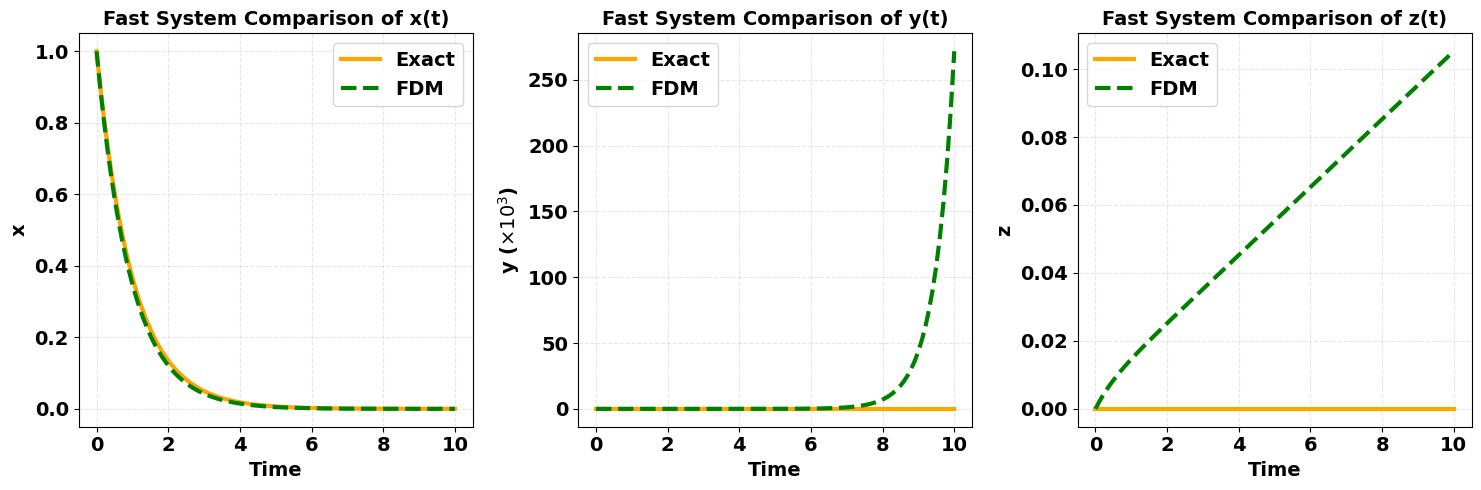

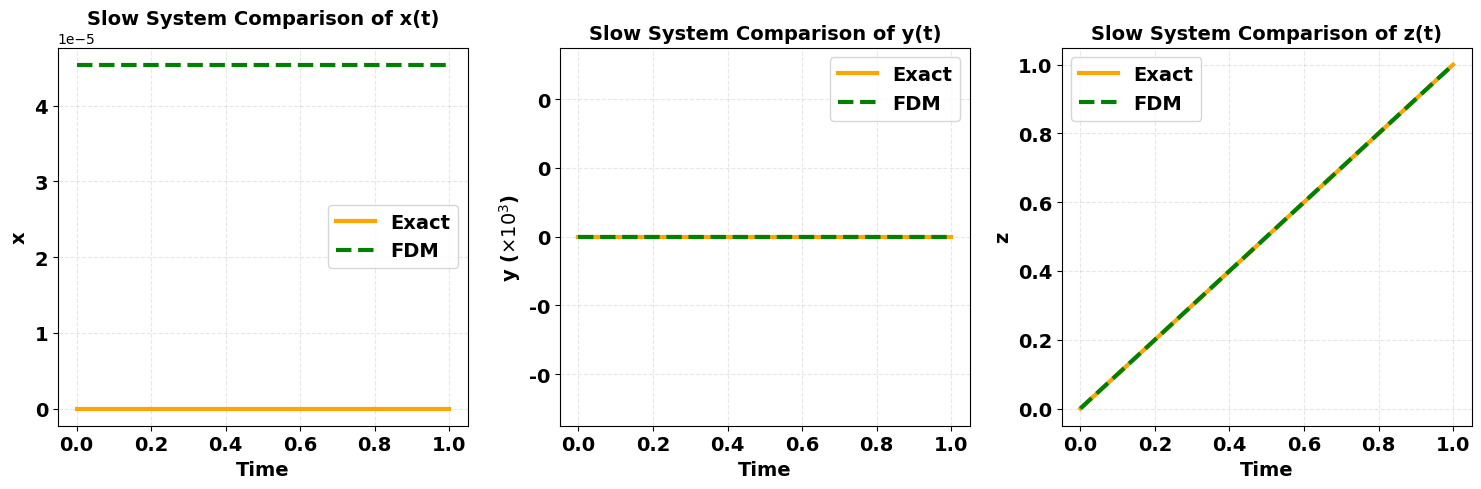

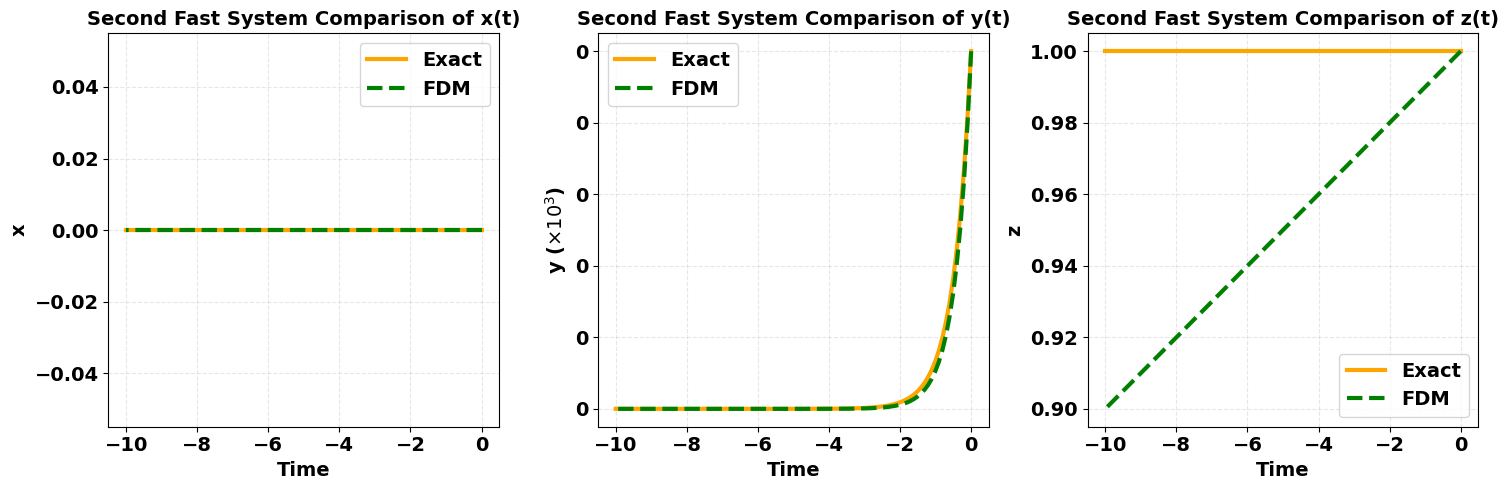

/tmp/ipykernel_18/648062550.py:102: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
/tmp/ipykernel_18/648062550.py:103: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
/tmp/ipykernel_18/648062550.py:104: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
/tmp/ipykernel_18/648062550.py:112: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


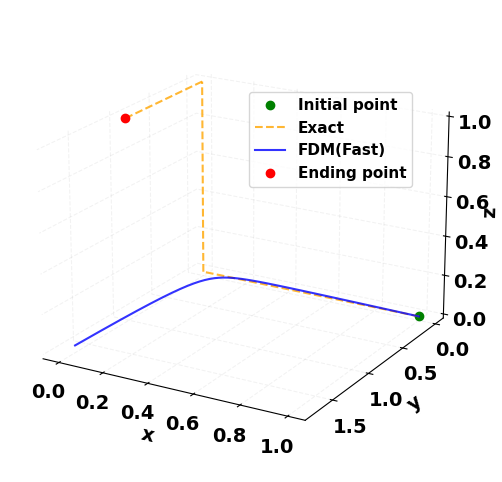

In [12]:
def main():
    t_end = 10
    t  =  np.linspace(0, t_end, 100)
    t2  =  np.linspace(0, -t_end, 100)
    
    T_slow_end = 1
    tau = np.linspace(0, T_slow_end, 100)

    #t = np.linspace(0, 20, 100)
    #t2 = np.linspace(0, -20, 100)
    #eps = 0.01
    x_init, y_init, z_init = 1.0, 0.0, 0.0
   

    start_time_exact = time.time()
    x_exact_fast, y_exact_fast, z_exact_fast = fast_solution(t, eps, x_init, y_init, z_init)
    xf_end, yf_end, zf_end = x_exact_fast[-1], y_exact_fast[-1], z_exact_fast[-1]
    x_exact_slow, y_exact_slow, z_exact_slow = slow_solution(tau, eps, xf_end, yf_end, zf_end)

    x_end, y_end, z_end = 0.0, 1.0, 1.0
    x_exact_fast2, y_exact_fast2, z_exact_fast2 = fast_solution(t2, eps, x_end, y_end, z_end)
    xf2_end, yf2_end, zf2_end = x_exact_fast2[-1], y_exact_fast2[-1], z_exact_fast2[-1]
    time_exact = time.time() - start_time_exact

    start_time_fdm = time.time()
    x_fdm_fast, y_fdm_fast, z_fdm_fast = fdm_solver_fast(t, eps, x_init, y_init, z_init)
    x_fdm_slow, y_fdm_slow, z_fdm_slow = fdm_solver_slow(tau, eps, xf_end, yf_end, zf_end)
    x_fdm_fast2, y_fdm_fast2, z_fdm_fast2 = fdm_solver_fast(t2, eps, x_end, y_end, z_end)
    time_fdm = time.time() - start_time_fdm

    print("\nCalculating error metrics...")
    # Fast forward system MSE
    mse_x_fdm_fast = mean_squared_error(x_exact_fast, x_fdm_fast)
    mse_y_fdm_fast = mean_squared_error(y_exact_fast, y_fdm_fast)
    mse_z_fdm_fast = mean_squared_error(z_exact_fast, z_fdm_fast)

    # Slow system MSE
    mse_x_fdm_slow = mean_squared_error(x_exact_slow, x_fdm_slow)
    mse_y_fdm_slow = mean_squared_error(y_exact_slow, y_fdm_slow)
    mse_z_fdm_slow = mean_squared_error(z_exact_slow, z_fdm_slow)

    # Backward fast system MSE
    mse_x_fdm_fast2 = mean_squared_error(x_exact_fast2, x_fdm_fast2)
    mse_y_fdm_fast2 = mean_squared_error(y_exact_fast2, y_fdm_fast2)
    mse_z_fdm_fast2 = mean_squared_error(z_exact_fast2, z_fdm_fast2)

    mse_total_fast = (mse_x_fdm_fast + mse_y_fdm_fast + mse_z_fdm_fast) / 3
    mse_total_slow = (mse_x_fdm_slow + mse_y_fdm_slow + mse_z_fdm_slow) / 3
    mse_total_fast2 = (mse_x_fdm_fast2 + mse_y_fdm_fast2 + mse_z_fdm_fast2) / 3

    print("\n===== Performance Comparison =====")
    print("\nComputation Time:")
    print(f"Exact Solution: {time_exact:.4f} seconds")
    print(f"FDM Solution: {time_fdm:.4f} seconds")

    print("\nMean Squared Error:")
    print("\nFast System:")
    print(f"MSE x: {mse_x_fdm_fast:.2e}")
    print(f"MSE y: {mse_y_fdm_fast:.2e}")
    print(f"MSE z: {mse_z_fdm_fast:.2e}")
    print(f"Average MSE: {mse_total_fast:.2e}")

    print("\nSlow System:")
    print(f"MSE x: {mse_x_fdm_slow:.2e}")
    print(f"MSE y: {mse_y_fdm_slow:.2e}")
    print(f"MSE z: {mse_z_fdm_slow:.2e}")
    print(f"Average MSE: {mse_total_slow:.2e}")

    print("\nSecond Fast System:")
    print(f"MSE x: {mse_x_fdm_fast2:.2e}")
    print(f"MSE y: {mse_y_fdm_fast2:.2e}")
    print(f"MSE z: {mse_z_fdm_fast2:.2e}")
    print(f"Average MSE: {mse_total_fast2:.2e}")

    print("\nGenerating plots...")
    plot_solutions(t, x_exact_fast, y_exact_fast, z_exact_fast, 
                  x_fdm_fast, y_fdm_fast, z_fdm_fast, "Fast System")
    
    plot_solutions(tau, x_exact_slow, y_exact_slow, z_exact_slow,
                  x_fdm_slow, y_fdm_slow, z_fdm_slow, "Slow System")
    
    plot_solutions(t2, x_exact_fast2, y_exact_fast2, z_exact_fast2,
                  x_fdm_fast2, y_fdm_fast2, z_fdm_fast2, "Second Fast System")

    plot_3d_trajectory(x_init, y_init, z_init, x_end, y_end, z_end,
                       z_exact_fast, x_exact_fast, y_exact_fast,
                      z_exact_slow, x_exact_slow, y_exact_slow,
                      z_exact_fast2, x_exact_fast2, y_exact_fast2,
                      z_fdm_fast, x_fdm_fast, y_fdm_fast,
                      z_fdm_slow, x_fdm_slow, y_fdm_slow,
                      z_fdm_fast2, x_fdm_fast2, y_fdm_fast2,
                      zf_end, xf_end, yf_end)
    
if __name__ == "__main__":
    main()